<a href="https://colab.research.google.com/github/shahnbej/pytorch/blob/main/Agricultural_crops_classification_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'agricultural-crops-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2436336%2F4122124%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T170018Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dad1aff5cac2682adb137f037b3e561c4b34aa0d63ece0e36469a6f36c1b1c2214b8d3cfa6d7632c537413f4f3537d92c5292dded4a794ab1cb22fa51c7e5558ebb65336bee034503cc54951af3933ca0bf82e53c919ce87fd9c287411fcdaac9c5c9a9317db354bf819167acaacfad268dce89d517ed8f8cde3a737b20b94137ca4b94610cb05de90da40e9f3f3d33cf1daf763765662f7410ed812aea24bce3184ff4edaf19e9607f96115bb59b07a4027f1f2e9795a467b710ef0740d1c58cc0cbce0457a3ffae082e1e3062830a35a81b41f785d30ab671e3792ada7859131221912b87de13e4a3fcc2003de7f99da67771548ac85573f56dd447797a3ecb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 82830492 bytes downloaded
Downloaded and uncompressed: agricultural-crops-image-classification
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install split-folders

In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 37.95 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [5]:
import torch
from torch import nn
import requests
import zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from typing import Tuple, Dict, List

In [6]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List
import random

In [8]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [9]:
input_folder='/kaggle/input/agricultural-crops-image-classification/Agricultural-crops'
import splitfolders
split_ratio = (0.9,0.0,0.1)
splitfolders.ratio( input_folder,
                  output='/kaggle/working/Dataset', seed=500,
                  ratio=split_ratio,
                  group_prefix=None,
                  )

Copying files: 829 files [00:00, 3848.28 files/s]


In [10]:
# Create a list with the filepaths for training and testing
trainpath = Path('../working/Dataset/train')
trainfilepaths = list(trainpath.glob(r'**/*.jpg'))

testpath = Path('../working/Dataset/test')
testfilepaths = list(testpath.glob(r'**/*.jpg'))

valpath = Path('../working/Dataset/val')
valfilepaths = list(testpath.glob(r'**/*.jpg'))

In [11]:
trainpath, len(trainfilepaths)

(PosixPath('../working/Dataset/train'), 490)

In [12]:
class_names, class_names_idx = find_classes(trainpath)
len(class_names)

30

In [13]:
def create_effnetb2_model(num_classes:int=50, seed:int=42):
    """
    Create an EfficientNetB2 features extrator model and transfroms.

    Args:
        num_classes (int, optional): number of classesin the classifier header
        Defaults to 50
        seed(int, optional): random seed value:Default to 42.

    Returns:
        model (torch.nn.Module): EffNet feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad=False

    # Changing classifier head with random seed
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace= True),
                                    nn.Linear(in_features=1408,out_features=num_classes)
                                    )
    return model, transforms

In [14]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=50, seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 117MB/s]


In [15]:
# # from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
# summary(effnetb2,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [16]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=trainpath,
                                                                                                test_dir=testpath,
                                                                                                transform= effnetb2_transforms,
                                                                                                batch_size=32)

In [17]:
train_dataloader_effnetb2, len(class_names)

(<torch.utils.data.dataloader.DataLoader at 0x7c2525a23790>, 30)

In [18]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

effnetb2_results = engine.train(model=effnetb2,
                               train_dataloader=train_dataloader_effnetb2,
                               test_dataloader= test_dataloader_effnetb2,
                               epochs=12,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               device=device)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3690 | train_acc: 0.1836 | test_loss: 2.8379 | test_acc: 0.6641
Epoch: 2 | train_loss: 2.4536 | train_acc: 0.6564 | test_loss: 2.1920 | test_acc: 0.7734
Epoch: 3 | train_loss: 1.8576 | train_acc: 0.7898 | test_loss: 1.7782 | test_acc: 0.7891
Epoch: 4 | train_loss: 1.4614 | train_acc: 0.8518 | test_loss: 1.4931 | test_acc: 0.8203
Epoch: 5 | train_loss: 1.2056 | train_acc: 0.8776 | test_loss: 1.2680 | test_acc: 0.8359
Epoch: 6 | train_loss: 0.9856 | train_acc: 0.9069 | test_loss: 1.1450 | test_acc: 0.8359
Epoch: 7 | train_loss: 0.8539 | train_acc: 0.9223 | test_loss: 0.9926 | test_acc: 0.8672
Epoch: 8 | train_loss: 0.6973 | train_acc: 0.9334 | test_loss: 0.9284 | test_acc: 0.8438
Epoch: 9 | train_loss: 0.6313 | train_acc: 0.9446 | test_loss: 0.8896 | test_acc: 0.8594
Epoch: 10 | train_loss: 0.5872 | train_acc: 0.9457 | test_loss: 0.7840 | test_acc: 0.8750
Epoch: 11 | train_loss: 0.5227 | train_acc: 0.9438 | test_loss: 0.7587 | test_acc: 0.8438
Epoch: 12 | train_l

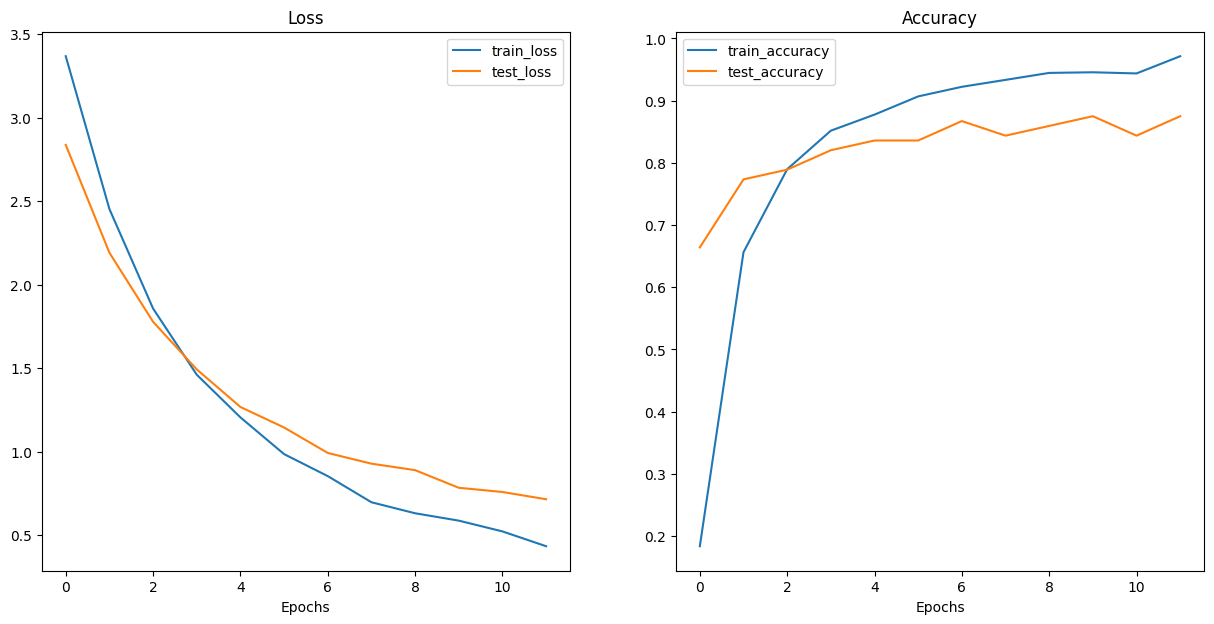

In [29]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

In [20]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2_feature_extractor_arg_crops_img_class.pth")

[INFO] Saving model to: models/effnetb2_feature_extractor_arg_crops_img_class.pth


In [21]:
# import and install Gradio

try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.4 MB/

In [22]:
# Put effnetb2 model on cpu
effnetb2.to("cpu")

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [23]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(img) -> Tuple[Dict, float]:
    """ Transforms and performs a predcition on img and returns predictrion and run time
    """
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():

        pred_probs = torch.softmax(effnetb2(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][1]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time


In [24]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(testpath).glob(r"**/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: ../working/Dataset/test/clove/images52.jpg

Prediction label and probability dictionary: 
{'Cherry': 0.07914454489946365, 'Coffee-plant': 0.07914454489946365, 'Cucumber': 0.07914454489946365, 'Fox_nut(Makhana)': 0.07914454489946365, 'Lemon': 0.07914454489946365, 'Olive-tree': 0.07914454489946365, 'Pearl_millet(bajra)': 0.07914454489946365, 'Tobacco-plant': 0.07914454489946365, 'almond': 0.07914454489946365, 'banana': 0.07914454489946365, 'cardamom': 0.07914454489946365, 'chilli': 0.07914454489946365, 'clove': 0.07914454489946365, 'coconut': 0.07914454489946365, 'cotton': 0.07914454489946365, 'gram': 0.07914454489946365, 'jowar': 0.07914454489946365, 'jute': 0.07914454489946365, 'maize': 0.07914454489946365, 'mustard-oil': 0.07914454489946365, 'papaya': 0.07914454489946365, 'pineapple': 0.07914454489946365, 'rice': 0.07914454489946365, 'soyabean': 0.07914454489946365, 'sugarcane': 0.07914454489946365, 'sunflower': 0.07914454489946365, 'tea': 0.0791445

In [25]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['../working/Dataset/test/vigna-radiati(Mung)/image (8).jpg'],
 ['../working/Dataset/test/Coffee-plant/images77.jpg'],
 ['../working/Dataset/test/Fox_nut(Makhana)/images24.jpg']]

In [26]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

In [33]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=testfilepaths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/70 [00:00<?, ?it/s]

In [34]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('../working/Dataset/test/wheat/image (44).jpg'),
  'class_name': 'wheat',
  'pred_prob': 0.8457,
  'pred_class': 'wheat',
  'time_for_pred': 0.1444,
  'correct': True},
 {'image_path': PosixPath('../working/Dataset/test/wheat/image (40).jpg'),
  'class_name': 'wheat',
  'pred_prob': 0.1625,
  'pred_class': 'mustard-oil',
  'time_for_pred': 0.1097,
  'correct': False}]

In [30]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['../working/Dataset/test/almond/image (5).jpg'],
 ['../working/Dataset/test/cardamom/image (5).jpg'],
 ['../working/Dataset/test/Tobacco-plant/images24.jpg']]

In [31]:
import gradio as gr

title = "Agriculture Crops Classification"
description = " An EfficentNetb2 feature extracto computer vision model to classify images of Agriculture Crops "
article = "Created from Agri crops image dataset"

demo = gr.Interface(fn=predict,
                    inputs= gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=50 , label="Predictions"),
                          gr.Number(label="Prediction time (s)")],
                   examples=example_list,
                   title=title,
                   description=description,
                   article=article)

demo.launch(debug=False,
           share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://82ce6c1c5a6abbf6fb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
# # Create path to Food101 class names
# foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# # Write Food101 class names list to file
# with open(foodvision_big_class_names_path, "w") as f:
#     print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
#     f.write("\n".join(food101_class_names)) # leave a new line between each class